# Raster data

```{admonition} Learning Objectives
*A 30 minute guide to raster data for SnowEX*
- find, visualize, interpret raster data formats
- reproject rasters to different coordinate reference systems
- use Python raster libraries [rasterio](https://github.com/mapbox/rasterio) and [rioxarray](https://corteva.github.io/rioxarray)
```

## Raster Basics

*Raster data is stored as a grid of values which are rendered on a map as pixels. Each pixel value represents an area on the Earth's surface.* Pixel values can be continuous (elevation) or categorical (land use).  This data structure is very common - jpg images on the web, photos from your digital camera. A geospatial raster is only unique in that it is accompanied by metadata that connects the pixel grid to a location on Earth's surface.

### Coordinate Reference System or "CRS"
This specifies the datum, projection, and additional parameters needed to place the raster in geographic space. For a dedicated lesson on CRSs, see: https://datacarpentry.org/organization-geospatial/03-crs/index.html

The natural representation of an image in programming is as an array, or matrix, with accompanying metadata to keep track of the geospatial information such as CRS. 

In [13]:
# It's good practice to keep track of the versions of various packages you are using
import rioxarray
import xarray as xr
import rasterio
import numpy as np
import os
import hvplot.xarray
print('rioxarray version:', rioxarray.__version__)
print('xarray version:', xr.__version__)
print('rasterio version:', rasterio.__version__)

# Work in a temporary directory
os.chdir('/tmp')

# Plotting setup
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
#plt.rcParams.update({'font.size': 16}) # make matplotlib font sizes bigger

rioxarray version: 0.4.3
xarray version: 0.18.2
rasterio version: 1.2.6


## Elevation rasters


Let's compare a few elevation rasters over Grand Mesa, CO. 

### NASADEM
First, let's look at NASADEM, which uses data from NASA's Shuttle Radar Topography Mission from February 11, 2000, but also fills in data gaps with the ASTER GDEM product.
Read more about this data set at https://lpdaac.usgs.gov/products/nasadem_hgtv001/. You can rind URLs to data via NASA's Earthdata search https://search.earthdata.nasa.gov:

* https://e4ftl01.cr.usgs.gov//DP132/MEASURES/NASADEM_HGT.001/2000.02.11/NASADEM_HGT_n39w109.zip 


In [45]:
# Get data from LPDAAC and unzip
!wget -q -nc https://e4ftl01.cr.usgs.gov//DP132/MEASURES/NASADEM_HGT.001/2000.02.11/NASADEM_HGT_n39w109.zip
!unzip -n NASADEM_HGT_n39w109.zip 

^C
unzip:  cannot find or open NASADEM_HGT_n39w109.zip, NASADEM_HGT_n39w109.zip.zip or NASADEM_HGT_n39w109.zip.ZIP.


### Rasterio

[rasterio](https://rasterio.readthedocs.io/en/latest/) is a foundational geospatial Python library to work with raster data. It is a Python library that builds on top of the [Geospatial Data Abstraction Library (GDAL)](https://gdal.org), a well-established and critical geospatial library that underpins most GIS software.

In [20]:
!aws --no-sign-request s3 cp s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif ./

download: s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif to ./Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif


In [21]:

# NOTE: This reads just the metadata into memory, not the whole file
path= 'Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif'
with rasterio.open(path) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3600, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -109.00013888888888,
       0.0, -0.0002777777777777778, 40.00013888888889), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


<class 'numpy.ndarray'>


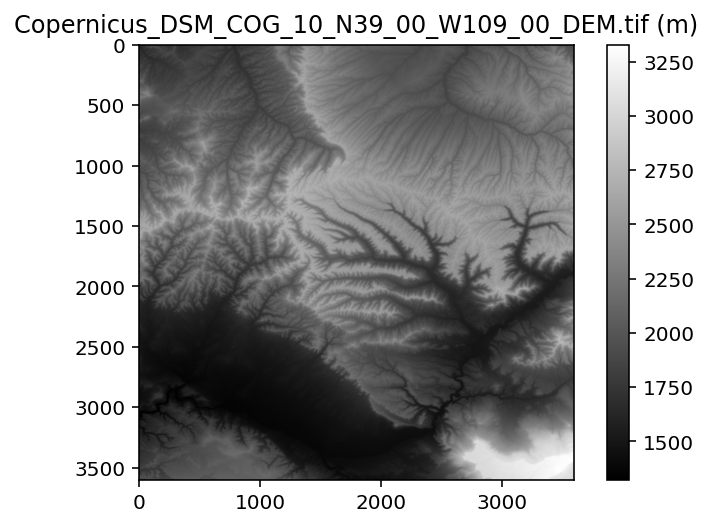

In [22]:
# We can read this raster data as a numpy array to perform calculations
with rasterio.open(path) as src:
    data = src.read(1) #read first band
    print(type(data))
    plt.imshow(data, cmap='gray')
    plt.colorbar()
    plt.title(f'{path} (m)')

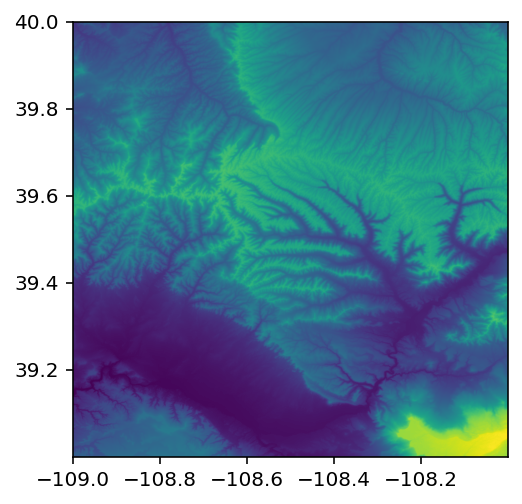

In [23]:
# Rasterio has a convenience function for plotting with geospatial coordinates
import rasterio.plot
with rasterio.open(path) as src:
    rasterio.plot.show(src)

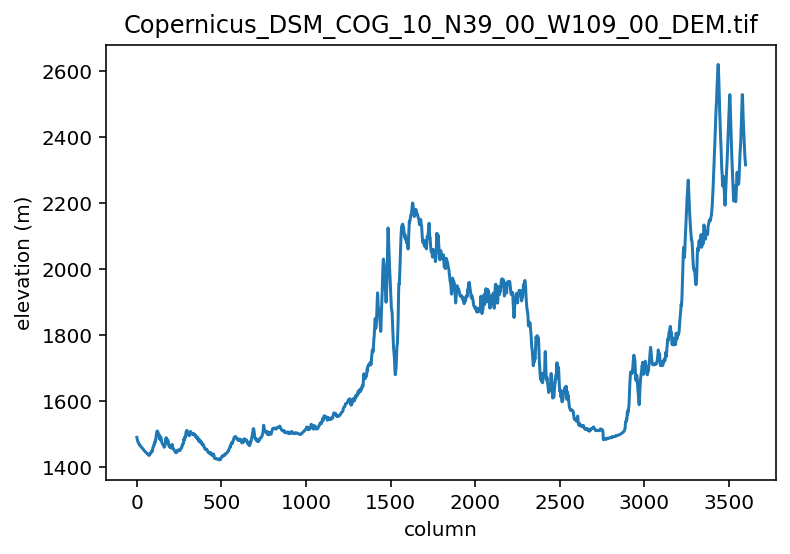

In [24]:
# rasterio knows about the 2D geospatial coordinates, so you can easily take a profile at a certain latitude
import rasterio.plot

latitude = 39.3
longitude = -108.8

with rasterio.open(path) as src:
    row, col = src.index(longitude, latitude)
    profile = data[row,:] # we already read in data earlier
    plt.plot(profile)
    plt.xlabel('column')
    plt.ylabel('elevation (m)')
    plt.title(path)

### Rioxarray

As the volume of digital data grows, it is increasingly common to work with n-dimensional data or "datacubes". The most basic example of a data cube is a stack of co-located images over time. Another example is multiband imagery where each band is acquired simultaneously. You can find a nice walk-through of concepts in this documentation from the [OpenEO project](https://openeo.org/documentation/1.0/datacubes.html). The Python library [Xarray](http://xarray.pydata.org/en/stable/) is designed to work efficiently with multidimensional datasets, and the extension [RioXarray](https://corteva.github.io/rioxarray/stable/) adds geospatial functionality such as reading and writing GDAL-supported data formats, CRS management, reprojection, etc. 

Rioxarray depends on rasterio for functionality (which in turn depends on GDAL), so you can see that it's software libraries all the way down!

In [26]:
da = rioxarray.open_rasterio(path, masked=True)
da

<xarray.DataArray (band: 1, y: 3600, x: 3600)>
[12960000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -109.0 -109.0 -109.0 ... -108.0 -108.0 -108.0
  * y            (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

```{note}
We have an `xarray DataArray`, which is convenient for datasets of one variable (in this case, elevation). The `xarray Dataset` is a related data intended for multiple data variables (elevation, precipitation, snow depth etc.),  Read more about xarray datastructures in the [documentation](http://xarray.pydata.org/en/stable/user-guide/data-structures.html). 
```

In [27]:
# Drop the 'band' dimension since we don't have multiband data
da = da.squeeze('band', drop=True)
da.name = 'nasadem'
da

<xarray.DataArray 'nasadem' (y: 3600, x: 3600)>
[12960000 values with dtype=float32]
Coordinates:
  * x            (x) float64 -109.0 -109.0 -109.0 ... -108.0 -108.0 -108.0
  * y            (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [28]:
# the rioxarray 'rio' accessor gives us access to geospatial information and other methods
print(da.rio.crs)
print(da.rio.encoded_nodata)

EPSG:4326
None


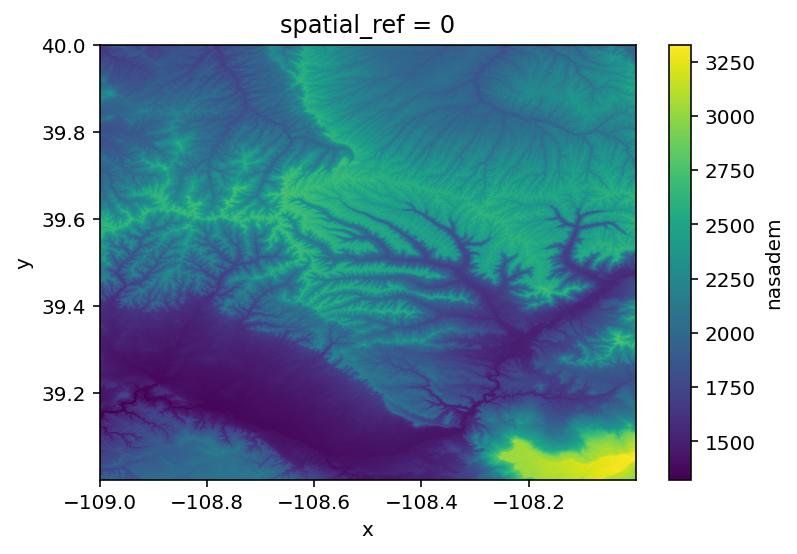

In [29]:
# xarray, like rasterio has built-in convenience plotting with matplotib
# http://xarray.pydata.org/en/stable/user-guide/plotting.html
da.plot();

In [30]:
# xarray is also integrated into holoviz plotting tools
# which are great for interactive data exploration in a browser
import hvplot.xarray
da.hvplot.image(x='x', y='y', rasterize=True, cmap='gray', 
                    aspect=1/np.cos(np.deg2rad(39)))

:DynamicMap   []
   :Image   [x,y]   (nasadem)

In [31]:
# Xarray uses pandas-style indexing to select data. This makes it very easy to plot a profile
profile = da.sel(y=39.3, method='nearest')
profile.hvplot.line(x='x')

:Curve   [x]   (nasadem)

In [40]:
# Finally, reproject this data to a different CRS and save it
# https://epsg.io/26912
da_reproject = da.rio.reproject("EPSG:26912")
da_reproject

<xarray.DataArray 'nasadem' (y: 4110, x: 3228)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)
Coordinates:
  * x            (x) float64 6.707e+05 6.708e+05 ... 7.597e+05 7.598e+05
  * y            (y) float64 4.432e+06 4.432e+06 ... 4.319e+06 4.319e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999.0

In [33]:
da_reproject.hvplot.image(x='x', y='y', rasterize=True, cmap='gray', 
                aspect=1, # NOTE: we change this since we're in UTM now
                )

:DynamicMap   []
   :Image   [x,y]   (nasadem)

In [34]:
# We can easily save the entire raster or a subset
da_reproject.rio.to_raster('n39w109_epsg26912.tif', driver='COG') #https://www.cogeo.org
# Load the saved dataset back in
#ds = xr.open_dataset('n39w109_epsg26912.tif', engine='rasterio')

## Comparing rasters

### Copernicus DEM
Second, let's get rasters from the European Space Agency Copernicus DEM, which is available as a public dataset on AWS: https://registry.opendata.aws/copernicus-dem/. This is a global digital elevation model derived from the TanDEM-X Synthetic Aperture Radar Mission, see [ESA's website for product details](https://spacedata.copernicus.eu/explore-more/news-archive/-/asset_publisher/Ye8egYeRPLEs/blog/id/434960)

* s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif

In [5]:
# Can use AWS CLI to interact with this data
!aws --no-sign-request s3 ls s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif

2020-11-24 21:16:20   40712353 Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif


In [6]:
# Rasterio has some capabilities to read URLs in addition to local file paths
url = 's3://copernicus-dem-30m/Copernicus_DSM_COG_10_N39_00_W109_00_DEM/Copernicus_DSM_COG_10_N39_00_W109_00_DEM.tif'

# need to use environment variables to change default GDAL settings when reading URLs
Env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                   AWS_NO_SIGN_REQUEST='YES')

# NOTE: this reads metadata only
with Env:
    with rasterio.open(url) as src:
        print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3600, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -109.00013888888888,
       0.0, -0.0002777777777777778, 40.00013888888889), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [9]:
# Because rioxarray uses rasterio & gdal it can also read urls
with Env:
    daC = rioxarray.open_rasterio(url).squeeze('band', drop=True)
    daC.name = 'copernicus_dem'

# NOTE: this data doesn't have NODATA set in metadata, so let's use the same value as SRTM
daC.rio.write_nodata(-32768.0, encoded=True, inplace=True)
daC

<xarray.DataArray 'copernicus_dem' (y: 3600, x: 3600)>
[12960000 values with dtype=float32]
Coordinates:
  * x            (x) float64 -109.0 -109.0 -109.0 ... -108.0 -108.0 -108.0
  * y            (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [16]:
daC.hvplot.image(x='x', y='y', rasterize=True, cmap='gray', 
                    aspect=1/np.cos(np.deg2rad(latitude)))

:DynamicMap   []
   :Image   [x,y]   (copernicus_dem)

In [35]:
# Ensure the grid of one raster exactly matches another (same projection, resolution, and extents)
# NOTE: these two raster happen to already be on an aligned grid
daR = daC.rio.reproject_match(da)
daR

<xarray.DataArray 'copernicus_dem' (y: 3600, x: 3600)>
array([[1702.1177, 1701.7124, 1699.4952, ..., 1921.0991, 1920.9246,
        1920.2612],
       [1694.4429, 1696.6843, 1696.0483, ..., 1922.5673, 1922.3778,
        1921.4277],
       [1679.9178, 1681.2617, 1680.4945, ..., 1923.4364, 1923.4009,
        1922.1167],
       ...,
       [1798.8859, 1805.069 , 1807.5242, ..., 3004.2627, 3001.4011,
        2998.252 ],
       [1795.9514, 1801.7977, 1799.6105, ..., 3004.403 , 3000.886 ,
        2996.5916],
       [1787.0204, 1791.5743, 1787.7576, ..., 3000.306 , 2998.202 ,
        2995.9846]], dtype=float32)
Coordinates:
  * x            (x) float64 -109.0 -109.0 -109.0 ... -108.0 -108.0 -108.0
  * y            (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [63]:
da

<xarray.DataArray 'nasadem' (y: 3600, x: 3600)>
array([[1702.1177, 1701.7124, 1699.4952, ..., 1921.0991, 1920.9246, 1920.2612],
       [1694.4429, 1696.6843, 1696.0483, ..., 1922.5673, 1922.3778, 1921.4277],
       [1679.9178, 1681.2617, 1680.4945, ..., 1923.4364, 1923.4009, 1922.1167],
       ...,
       [1798.8859, 1805.069 , 1807.5242, ..., 3004.2627, 3001.4011, 2998.252 ],
       [1795.9514, 1801.7977, 1799.6105, ..., 3004.403 , 3000.886 , 2996.5916],
       [1787.0204, 1791.5743, 1787.7576, ..., 3000.306 , 2998.202 , 2995.9846]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -109.0 -109.0 -109.0 ... -108.0 -108.0 -108.0
  * y            (y) float64 40.0 40.0 40.0 40.0 40.0 ... 39.0 39.0 39.0 39.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [57]:
difference = daR - da
difference.name = 'cop30 - nasadem'
plot = difference.hvplot.image(x='x', y='y', rasterize=True, cmap='bwr', clim=(-50,50),
                               aspect=1/np.cos(np.deg2rad(latitude)))
plot

:DynamicMap   []
   :Image   [x,y]   (cop30 - nasadem)

In [46]:
import holoviews as hv
mean = difference.mean().values
print(mean)
mean_hline = hv.VLine(mean)
# Composite plot with holoviz (histogram with line overlay)
difference.hvplot.hist(bins=100, xlim=(-50,50), color='gray') * mean_hline.opts(color='red')

0.0


:Overlay
   .NdOverlay.I :NdOverlay   [Element]
      :Histogram   [cop30 - nasadem]   (cop30 - nasadem_count)
   .VLine.I     :VLine   [x,y]

```{warning}

NOTE that both the NASA DEM and Copernicus DEM report a CRS of `CRS.from_epsg(4326)`. This is the 2D horizontal coordinate reference. Elevation values also are with respect to a reference surface known as a datum, which is commonly an ellipsoid representation of the Earth, or a spatially varying "geoid" which is an equipotential surface. For high-precision geodetic applications it is common to use even more accurate time-varying [3D coordinate reference systems](https://proj.org/usage/transformation.html#).

For NASADEM, according to the documentation page the datum is WGS84/EGM96, where 'EGM96' is the 'Earth Geoid Model from 1996'. But the Copernicus DEM uses EGM2008, a slightly updated model. Often, GNSS elevation datasets and SAR products are relative to elliposid heights (EPSG:4979), and if you do not convert between these systems you might end up with elevation discrepancies on the order of 100 meters!

Datum shift grids can be used to vertically shift rasters and can be read about here https://proj.org/usage/network.html
```

In [51]:
with Env:
    daS = rioxarray.open_rasterio('https://cdn.proj.org/us_nga_egm96_15.tif').squeeze(dim='band', drop=True)
    daS.name = 'us_nga_egm96_15'

In [52]:
# World - WGS 84 (EPSG:4979) to EGM96 height (EPSG:5773). Size: 2.6 MB. Last modified: 2020-01-24
from cartopy import crs

daS.hvplot.image(x='x', y='y', rasterize=True,
                geo=True, global_extent=True, coastline=True,
                cmap='bwr', projection=crs.Mollweide(),
                title='WGS 84 (EPSG:4979) to EGM96 height (EPSG:5773)')

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


:DynamicMap   []
   :Overlay
      .Image.I     :Image   [x,y]   (us_nga_egm96_15)
      .Coastline.I :Feature   [Longitude,Latitude]

In [53]:
# What is the approximate grid shift at a specific location? 
daS.sel(x=longitude, y=latitude, method='nearest').values

array(-17.153917, dtype=float32)

```{admonition} execercises
- find longitude, latitude point of maximum EPSG:4979 -> EPSG:5773 datum shift magnitude
- convert both elevation datasets to ellipsoid height (EPSG:4979) using data shift grids
- save a small subset of a raster dataset
```